In [1]:
# !pip install evaluate

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../")

In [4]:
from pathlib import Path

MODELS_DIR = Path("../data/models")
MODELS_DIR.resolve()

PosixPath('/home/djaniak/projects/information-bottleneck/data/models')

In [5]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [6]:
import json
import os
from pathlib import Path


data_dir = Path("../data/entropies/gptq-wikitext2")
entropies = []

for entropies_file in data_dir.rglob("*.json"):
    with open(entropies_file, "r") as f:
        p = json.load(f)
    entropies.append(p)

In [7]:
import pandas as pd

df = pd.DataFrame(entropies)
df["model_name"] = df["model"].apply(lambda x: x.split("/")[-1])

df.head()

,model,quantization,bits,dataset,ppl,entropy,logD_normalized_entropy,logN_normalized_entropy,NlogD_normalized_entropy,model_name
0,facebook/opt-2.7b,gptq,16,wikitext2,12.506627,5.425678,0.691366,0.711600,0.000338,opt-2.7b
1,facebook/opt-2.7b,gptq,2,wikitext2,120.847733,5.127506,0.653372,0.672493,0.000319,opt-2.7b
2,facebook/opt-13b,gptq,8,wikitext2,10.180621,5.708210,0.668338,0.748655,0.000326,opt-13b
3,facebook/opt-13b,gptq,16,wikitext2,10.181063,5.708405,0.668360,0.748681,0.000326,opt-13b
4,facebook/opt-2.7b,gptq,4,wikitext2,12.862996,5.442557,0.693517,0.713814,0.000339,opt-2.7b


In [8]:
def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(filepath):
                total_size += os.path.getsize(filepath)
    return total_size


def read_model_dir_size(model: str, bits: int):
    if bits < 16:
        model_dir = MODELS_DIR / "quantized" /(model.replace("/", "_") + f"-gptq-{bits}bit-128g-wikitext2")
    else:
        model_dir = MODELS_DIR / "original" / model.replace("/", "_")
    assert model_dir.exists()
    return get_directory_size(model_dir)

df["size"] = df.apply(lambda x: read_model_dir_size(x["model"], x["bits"]), axis=1)
df["size [MB]"] = df["size"].apply(lambda x: x / (1024**2))
df["size [GB]"] = df["size"].apply(lambda x: x / (1024**3))

In [9]:
df.sort_values(by=["model", "bits"]).head(5)

,model,quantization,bits,dataset,ppl,entropy,logD_normalized_entropy,logN_normalized_entropy,NlogD_normalized_entropy,model_name,size,size [MB],size [GB]
6,facebook/opt-1.3b,gptq,2,wikitext2,252.313187,5.298427,0.694910,0.694910,0.000339,opt-1.3b,746600224,712.013458,0.695326
7,facebook/opt-1.3b,gptq,3,wikitext2,17.655552,5.399457,0.708161,0.708161,0.000346,opt-1.3b,898774920,857.138557,0.837049
11,facebook/opt-1.3b,gptq,4,wikitext2,16.304638,5.357017,0.702595,0.702595,0.000343,opt-1.3b,1050950376,1002.264381,0.978774
12,facebook/opt-1.3b,gptq,8,wikitext2,15.928323,5.325886,0.698512,0.698512,0.000341,opt-1.3b,1659648992,1582.764618,1.545669
19,facebook/opt-1.3b,gptq,16,wikitext2,14.777081,5.363237,0.703410,0.703410,0.000343,opt-1.3b,2631562561,2509.653626,2.450834


In [10]:
df.sort_values(by=["model", "bits"]).tail(5)

,model,quantization,bits,dataset,ppl,entropy,logD_normalized_entropy,logN_normalized_entropy,NlogD_normalized_entropy,model_name,size,size [MB],size [GB]
16,facebook/opt-6.7b,gptq,2,wikitext2,25.147749,5.680540,0.682941,0.745026,0.000333,opt-6.7b,2572581353,2453.404763,2.395903
5,facebook/opt-6.7b,gptq,3,wikitext2,11.500744,5.631138,0.677001,0.738547,0.000331,opt-6.7b,3384179433,3227.405007,3.151763
17,facebook/opt-6.7b,gptq,4,wikitext2,11.043609,5.616047,0.675187,0.736568,0.000330,opt-6.7b,4195777377,4001.405122,3.907622
10,facebook/opt-6.7b,gptq,8,wikitext2,10.827029,5.575162,0.670272,0.731205,0.000327,opt-6.7b,7442169193,7097.405618,6.931060
18,facebook/opt-6.7b,gptq,16,wikitext2,10.821783,5.575312,0.670290,0.731225,0.000327,opt-6.7b,13317054771,12700.133105,12.402474


# Perplexity

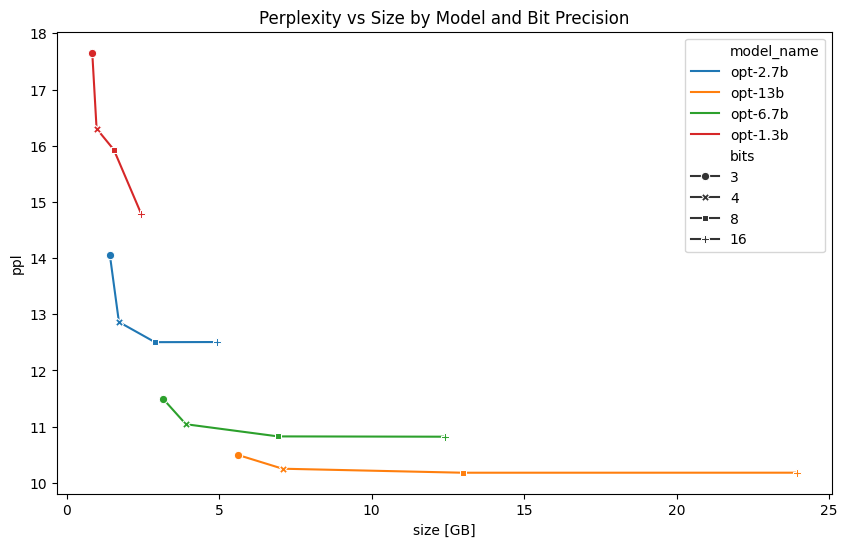

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as desired

ax1 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y="ppl",
    hue="model_name",
    markers=True,
    dashes=False,
    legend=False
)
ax2 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y="ppl",
    hue="model_name",
    style="bits",
    markers=True,
    dashes=False,
)

plt.xlabel('size [GB]')
plt.ylabel('ppl')
plt.title('Perplexity vs Size by Model and Bit Precision')
plt.show()


# Entropy

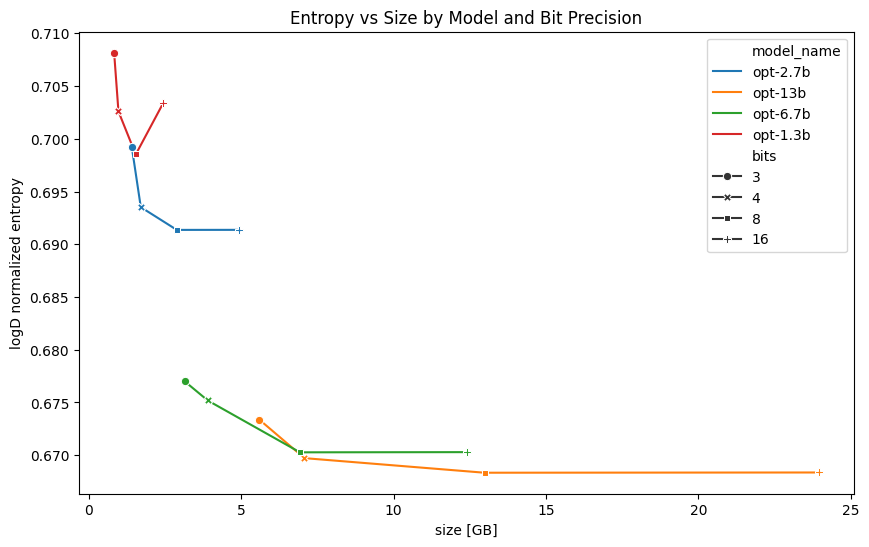

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as desired

entropy = "logD_normalized_entropy"

ax1 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y=entropy,
    hue="model_name",
    markers=True,
    dashes=False,
    legend=False
)
ax2 = sns.lineplot(
    data=df[df['bits'] > 2],
    x="size [GB]",
    y=entropy,
    hue="model_name",
    style="bits",
    markers=True,
    dashes=False,
)

plt.xlabel('size [GB]')
plt.ylabel('Entropy')
plt.ylabel(" ".join(entropy.split("_")))
plt.title('Entropy vs Size by Model and Bit Precision')
# plt.yscale('log')
plt.show()
